In [ ]:
pip install cleverhans

#Train models on MNIST with PGD or FGM technique

###Import packages, set seed

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
#from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
import os
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, cifar10
import random
#set every seed possible seed
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

###Define model architecture

In [3]:
class Net(Model):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2D(32, 3, strides=(1, 1), activation="relu", padding="same")
        self.conv2 = Conv2D(64, 3, strides=(1, 1), activation="relu", padding="valid")
        self.flatten = Flatten()
        self.dense1 = Dense(64, activation="relu")
        self.dense2 = Dense(10, activation="softmax")

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

### Define how we load in the data

In [4]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load(
        "mnist", data_dir="gs://tfds-data/datasets", with_info=True, as_supervised=True
    )
    mnist_train, mnist_test = dataset["train"].take(10000), dataset["test"].take(10000)   ## define how many samples from the set
    mnist_train = mnist_train.map(convert_types).shuffle(30000).batch(160)  ## Set batch size
    mnist_test = mnist_test.map(convert_types).batch(160)  ## Set batch size
    return EasyDict(train=mnist_train, test=mnist_test)


###Define function that trains the model

In [5]:
def main():
    # Load training and test data
    data = ld_mnist()
    model = Net()
    loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.optimizers.Adam(learning_rate=0.001)

    # Metrics to track the different accuracies.
    train_loss = tf.metrics.Mean(name="train_loss")
    test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
    test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
    test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(y, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

    # Train model with adversarial training
    for epoch in range(20):  ##define epochs
        # keras like display of progress
        progress_bar_train = tf.keras.utils.Progbar(30000) ## set how big the bar is
        for (x, y) in data.train:
            if True:
                # Replace clean example with adversarial example for adversarial training
                x = projected_gradient_descent(model, x, 0.3, 0.01, 30, np.inf)
            train_step(x, y)
            progress_bar_train.add(x.shape[0], values=[("loss", train_loss.result())])

    # Evaluate on clean and adversarial data
    progress_bar_test = tf.keras.utils.Progbar(30000)
    for x, y in data.test:
        y_pred = model(x)
        test_acc_clean(y, y_pred)

        x_fgm = fast_gradient_method(model, x, 0.3, np.inf)
        y_pred_fgm = model(x_fgm)
        test_acc_fgsm(y, y_pred_fgm)

        x_pgd = projected_gradient_descent(model, x, 0.3, 0.01, 30, np.inf)
        y_pred_pgd = model(x_pgd)
        test_acc_pgd(y, y_pred_pgd)

        progress_bar_test.add(x.shape[0])

    print(
        "test acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100)
    )
    print(
        "test acc on FGM adversarial examples (%): {:.3f}".format(
            test_acc_fgsm.result() * 100
        )
    )
    print(
        "test acc on PGD adversarial examples (%): {:.3f}".format(
            test_acc_pgd.result() * 100
        )
    )
    return model, data

### Train model

In [171]:
if __name__ == "__main__":

  model, data =main()

10000/30000 [=========>....................] - ETA: 28stest acc on clean examples (%): 98.010
test acc on FGM adversarial examples (%): 92.000
test acc on PGD adversarial examples (%): 88.510


# Save model

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
model.save_weights('/content/drive/MyDrive/Secure_models/PGD160')


## Redefine model


In [166]:
# Create a new model instance
model = Net()
# Restore the weights
model.load_weights('/content/drive/MyDrive/Secure_models/PGD10240')

## turn easy dict to np array

In [179]:
#dataset = data.train
dataset = data.test
# Initialize lists to store images and labels
images = []
labels = []
# Iterate through the dataset
for img_tensor, label_tensor in dataset:
    # Convert tensors to numpy arrays and append to lists
    images.append(img_tensor.numpy())
    labels.append(label_tensor.numpy())

# Convert lists to numpy arrays
images_np = np.array(images)
labels_np = np.array(labels)

<ipython-input-179-3e9b74d9aac5>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_np = np.array(images)
<ipython-input-179-3e9b74d9aac5>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_np = np.array(labels)


##Define dataframe to store results

In [173]:
import pandas as pd
df = pd.DataFrame(columns=['train', 'test'])
df['train'] = []
df['test'] = []


## Testing membership accuracy attack

In [174]:
# Define the membership score function
def membership_score(model, image, true_label):
    prediction = model.predict(image[np.newaxis, :])
    #print(prediction)
    score = np.mean(prediction[:, true_label])
    return score

###Get average of the set

In [ ]:
total = 0
totalscore = 0
for i in range(62):
  for j in range(160):
    score = membership_score(model, images_np[i][j], labels_np[i][j])
    #df.loc[total]=[score,0]
    df['test'].iloc[total]=score
    totalscore+=score
    total+=1

print(totalscore/total)

## Plot results if you'd like

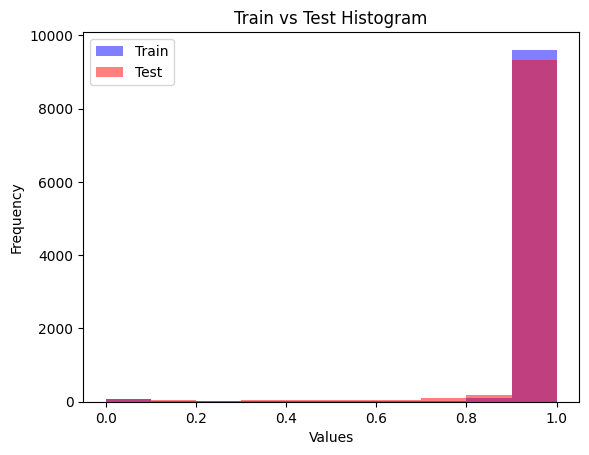

In [181]:
# Plotting
plt.hist(df['train'], alpha=0.5, label='Train', color='blue')
plt.hist(df['test'], alpha=0.5, label='Test', color='red')


plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Train vs Test Histogram')
plt.legend()
plt.savefig('myplot.png')
plt.show()

## Test/train accuracy

In [ ]:
total = 0
correct = 0
for i in range(33,62):
  for j in range(160):
    total+=1

    score = membership_score(model, images_np[i][j], labels_np[i][j])

    #print(score)
    if score <= 0.977666825:
      correct+=1
print(correct/total)

1/1 [==============================] - 0s 30ms/step


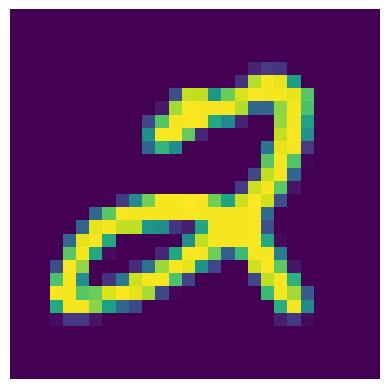

Membership score: 0.9999248


In [ ]:
test_image=images_np[0][0]

# Compute the membership score for the test image
score = membership_score(model, test_image, labels_np[0][0])

# Plot the test image and print the membership score
plt.imshow(test_image)
plt.axis('off')
plt.show()
print('Membership score:', score)